In [1]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
# Instalar las librerías necesarias
%pip install requests
%pip install kneed



Note: you may need to restart the kernel to use updated packages.


In [36]:
# Importar librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
import requests
from io import StringIO



# Lectura del dataset
Utilizaremos el conjunto de datos de calidad del vino. Este conjunto de datos contiene varias propiedades químicas del vino, como la acidez, el azúcar, el pH y el alcohol. También contiene una métrica de calidad (3-9, siendo mejor la más alta) y un color (rojo o blanco).

In [23]:
# URL del archivo CSV en GitHub
url = 'https://raw.githubusercontent.com/osiris-contreras/Osiris-Contreras-Trillos-/main/Wine_Quality_Data.csv'

# Obtener los datos del archivo CSV
response = requests.get(url)
csv_data = response.content.decode('utf-8')

# Leer los datos del archivo CSV utilizando pandas
df = pd.read_csv(StringIO(csv_data))

# Mostrar las primeras filas del DataFrame
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [28]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [32]:
# Descripción estadística general de las variables categóricas
df.describe(include=['object'])

,color
count,6497
unique,2
top,white
freq,4898


In [33]:
# Comprobación de valores duplicados
df.duplicated().sum()

1177

In [40]:
# Eliminación de valores duplicados
df2 = df.drop_duplicates()

# Comprobación de valores duplicados
df2.duplicated().sum()
df2.shape

(5320, 13)

In [41]:
# Descripción estadística general de las variables categóricas
df2.describe(include=['object'])

,color
count,5320
unique,2
top,white
freq,3961


In [35]:
float_columns = [x for x in df2.columns if x not in ['color', 'quality']]

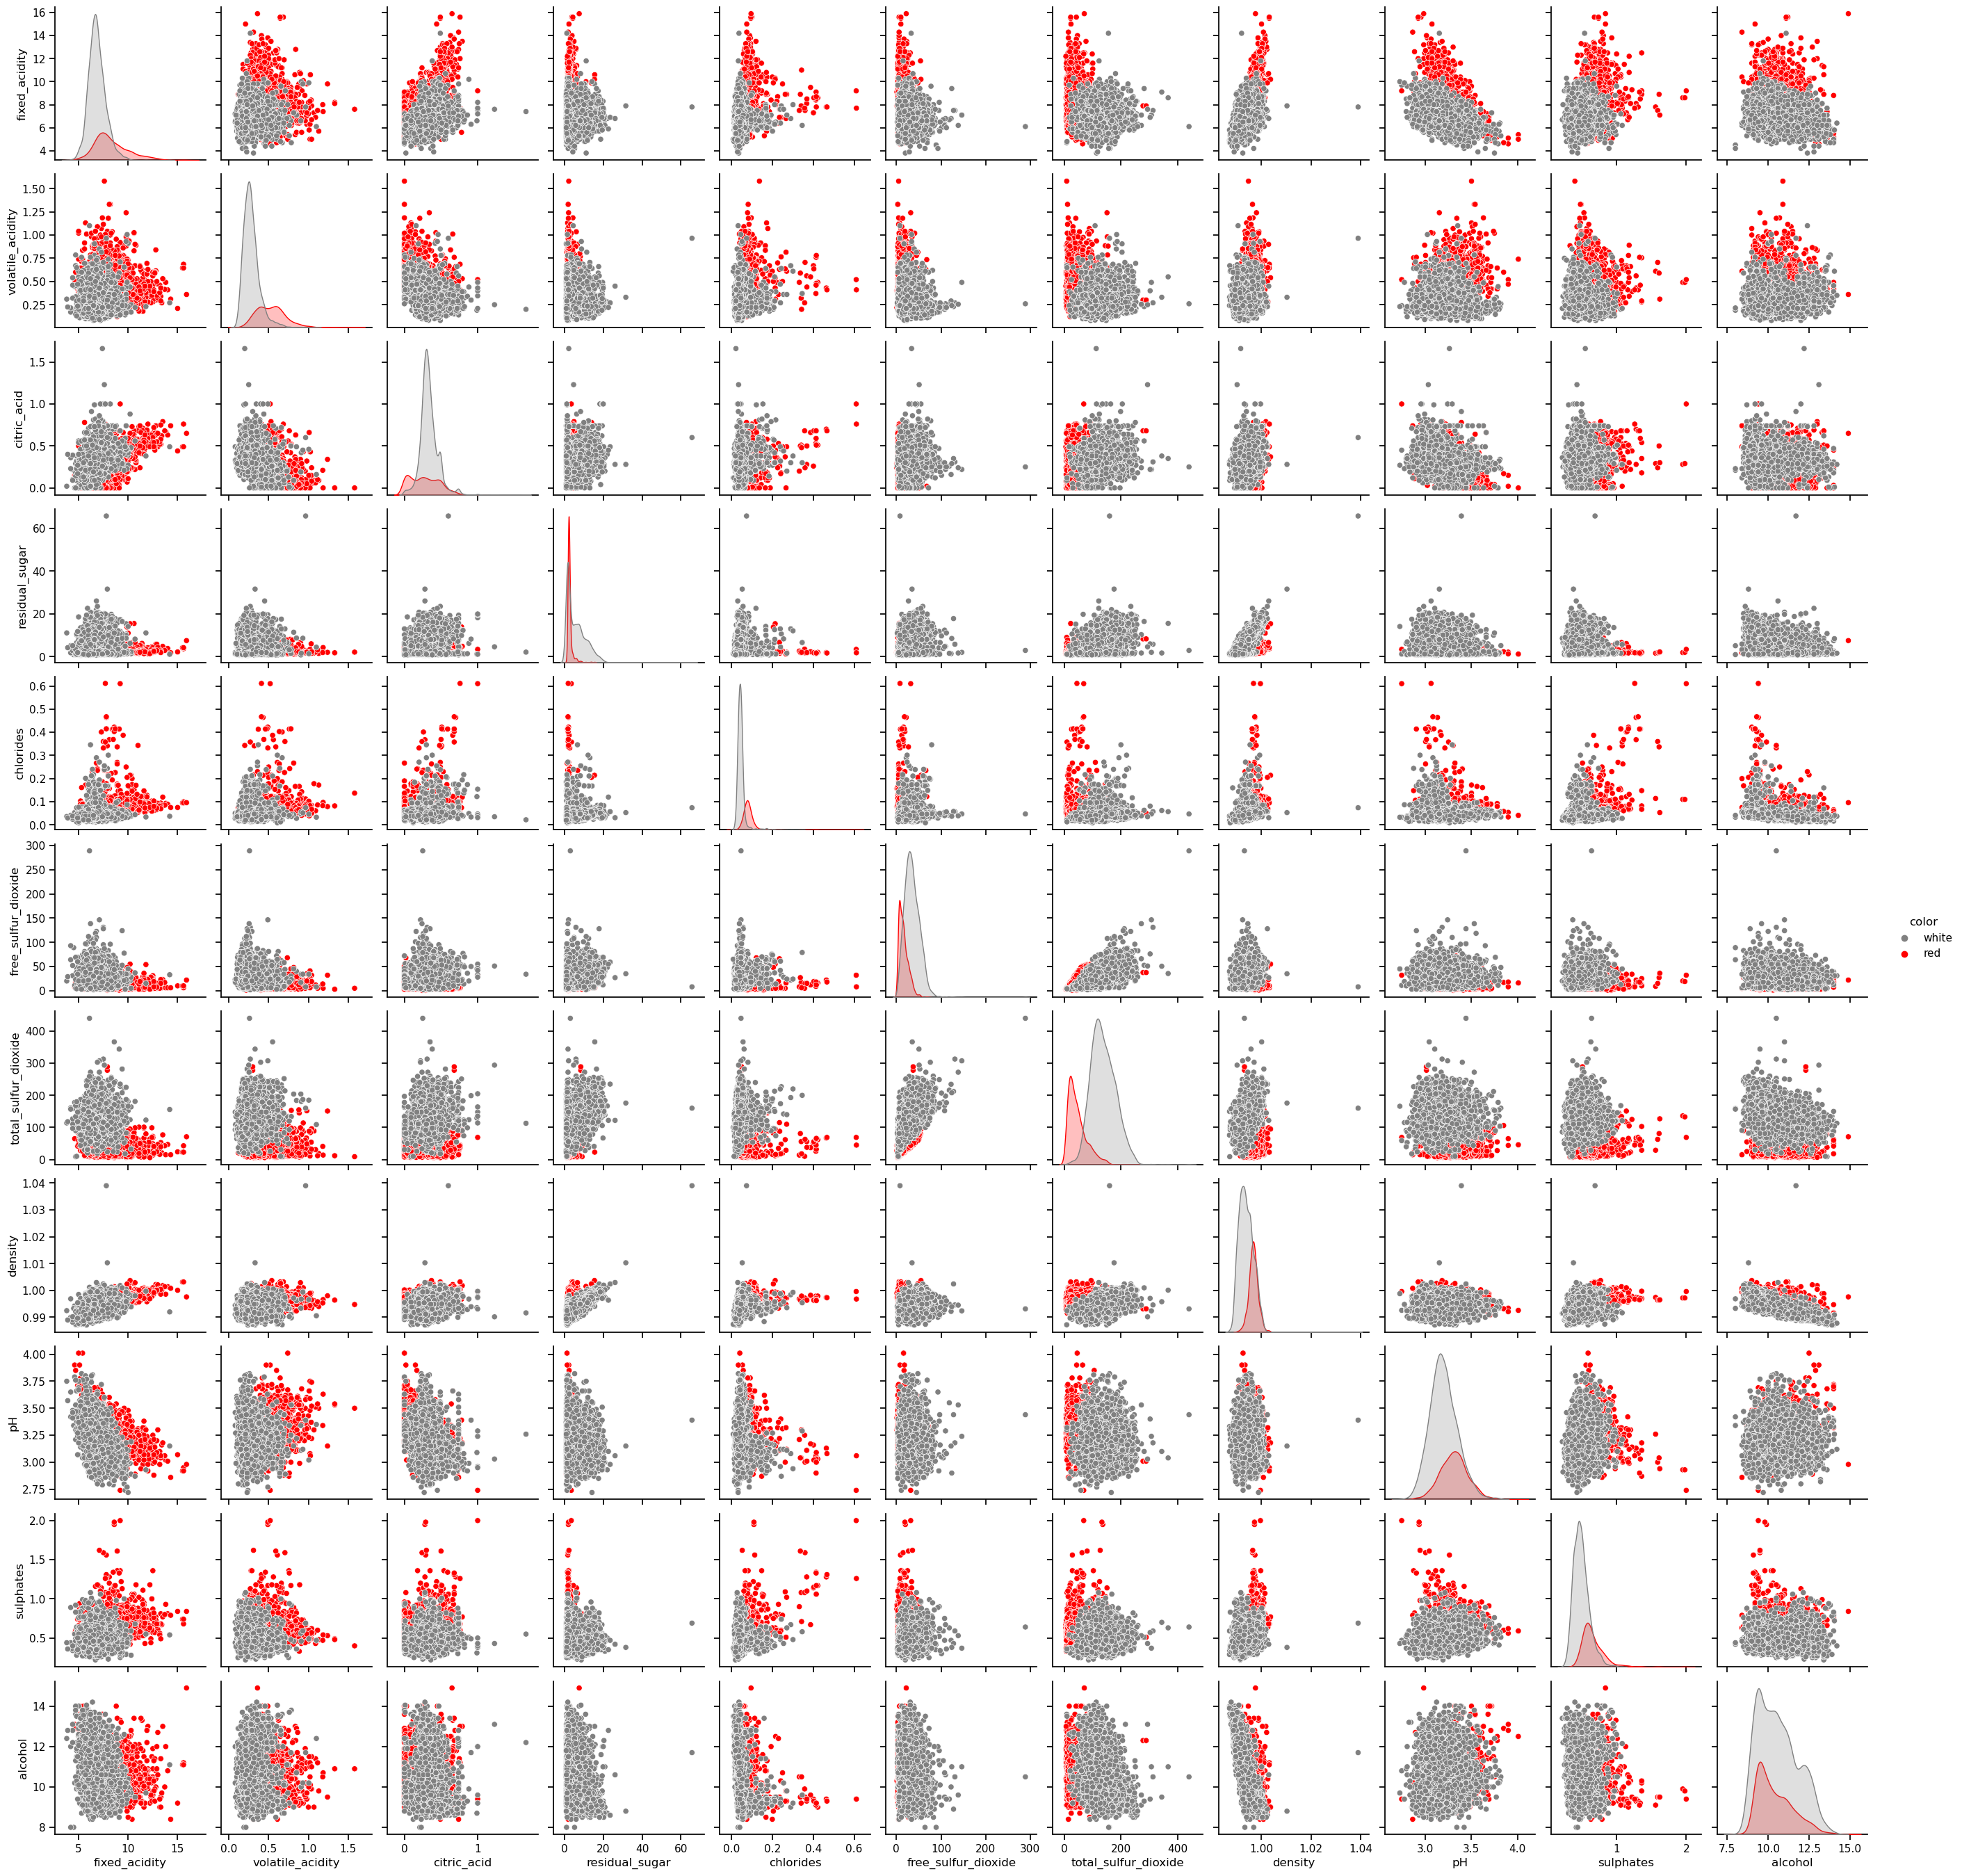

In [37]:
temp = df2[float_columns + ['color']]

sns.set_context('notebook')
sns.pairplot(temp, 
             hue='color', 
             hue_order=['white', 'red'],
             palette={'red':'red', 'white':'gray'});

In [39]:
# Scaling data 
scaler = StandardScaler()
scaler.fit(df2)
scaled = pd.DataFrame(scaler.transform(df2),columns = df2.columns)

# Scaled data
scaled.head()

ValueError: could not convert string to float: 'red'